# Fraud Detection Pipeline
## IEEE-CIS Transaction Dataset + Elliptic Bitcoin Graph Dataset

This notebook covers the full pipeline:
1. Data loading and merging
2. Exploratory Data Analysis
3. Missing value handling with documented strategies
4. Temporal train/validation/test split
5. Entity-level feature engineering (behavioral, velocity, graph)
6. Class imbalance handling
7. Model training (XGBoost + TabNet)
8. Evaluation metrics
9. SHAP explainability
10. False positive analysis

## 1. Imports and Configuration

In [1]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 9.7.0
ipykernel        : 6.31.0
ipywidgets       : 8.1.7
jupyter_client   : 8.6.3
jupyter_core     : 5.8.1
jupyter_server   : 2.16.0
jupyterlab       : 4.4.7
nbclient         : 0.10.2
nbconvert        : 7.16.6
nbformat         : 5.10.4
notebook         : 7.4.5
qtconsole        : 5.7.0
traitlets        : 5.14.3


In [2]:
pip install numpy pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn torch shap networkx scipy joblib fastapi uvicorn pydantic

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install shap
import shap
print(shap.__version__)

0.50.0


In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import shap
import joblib
import json

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, classification_report,
    confusion_matrix, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

SEED = 42
np.random.seed(SEED)

DATA_DIR = Path('../data')
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

print('All imports successful')
print('PyTorch version:', torch.__version__)

All imports successful
PyTorch version: 2.10.0+cpu


## 2. Data Loading

In [5]:
print('Loading IEEE-CIS datasets...')


train_transaction = pd.read_csv("DATA_DIR/train_transaction.csv")
train_identity    = pd.read_csv("DATA_DIR/train_identity.csv")
test_transaction  = pd.read_csv("DATA_DIR/test_transaction.csv")
test_identity     = pd.read_csv("DATA_DIR/test_identity.csv")

print(f'Train transaction shape : {train_transaction.shape}')
print(f'Train identity shape    : {train_identity.shape}')
print(f'Test transaction shape  : {test_transaction.shape}')
print(f'Test identity shape     : {test_identity.shape}')

Loading IEEE-CIS datasets...
Train transaction shape : (590540, 394)
Train identity shape    : (144233, 41)
Test transaction shape  : (506691, 393)
Test identity shape     : (141907, 41)


In [6]:
import pandas as pd

print('Loading Elliptic Bitcoin datasets...')

elliptic_classes  = pd.read_csv("DATA_DIR/elliptic_txs_classes.csv")
elliptic_edgelist = pd.read_csv("DATA_DIR/elliptic_txs_edgelist.csv")

# The features CSV has no proper header. First column is txId, rest are 166 anonymized features.
elliptic_features = pd.read_csv(
    "DATA_DIR/elliptic_txs_features.csv",
    header=None
)

elliptic_features.columns = ['txId'] + [f'elliptic_feat_{i}' for i in range(1, elliptic_features.shape[1])]

print(f'Elliptic classes shape  : {elliptic_classes.shape}')
print(f'Elliptic edgelist shape : {elliptic_edgelist.shape}')
print(f'Elliptic features shape : {elliptic_features.shape}')
print(f'Class distribution      :\n{elliptic_classes["class"].value_counts()}')

Loading Elliptic Bitcoin datasets...
Elliptic classes shape  : (203769, 2)
Elliptic edgelist shape : (234355, 2)
Elliptic features shape : (203769, 167)
Class distribution      :
class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64


## 3. Merging Transaction and Identity Data

Not every transaction has identity data. We use a left join on TransactionID to preserve all transactions. Missing identity fields will be handled in the imputation step.

In [7]:
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test  = test_transaction.merge(test_identity,   on='TransactionID', how='left')

print(f'Merged train shape : {train.shape}')
print(f'Merged test shape  : {test.shape}')
print(f'Fraud rate         : {train["isFraud"].mean():.4f}')
print(f'Transactions with identity data: {train_identity["TransactionID"].nunique()} / {len(train_transaction)}')

Merged train shape : (590540, 434)
Merged test shape  : (506691, 433)
Fraud rate         : 0.0350
Transactions with identity data: 144233 / 590540


## 4. Exploratory Data Analysis

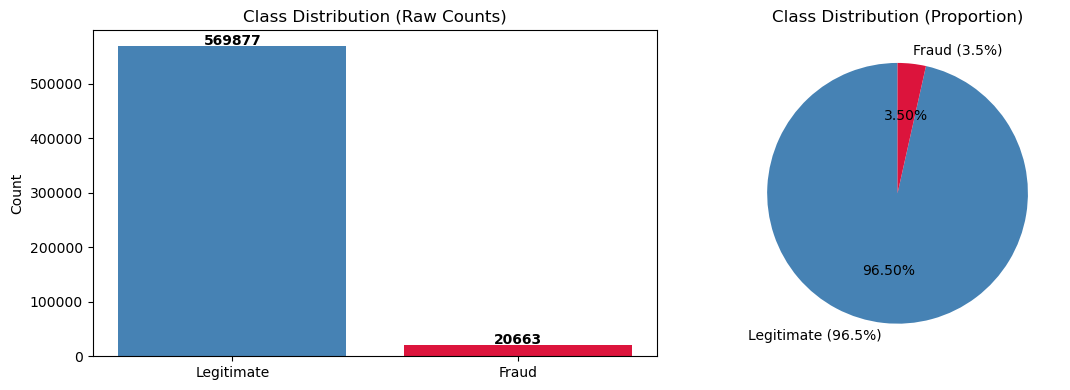

Imbalance ratio: 1 fraud for every 27 legitimate transactions


In [9]:
# Class imbalance visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

fraud_counts = train['isFraud'].value_counts()
axes[0].bar(['Legitimate', 'Fraud'], fraud_counts.values, color=['steelblue', 'crimson'])
axes[0].set_title('Class Distribution (Raw Counts)')
axes[0].set_ylabel('Count')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 1000, str(v), ha='center', fontweight='bold')

axes[1].pie(
    fraud_counts.values,
    labels=['Legitimate (96.5%)', 'Fraud (3.5%)'],
    colors=['steelblue', 'crimson'],
    autopct='%1.2f%%',
    startangle=90
)
axes[1].set_title('Class Distribution (Proportion)')

plt.tight_layout()
plt.savefig('reports/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Imbalance ratio: 1 fraud for every {int(fraud_counts[0]/fraud_counts[1])} legitimate transactions')

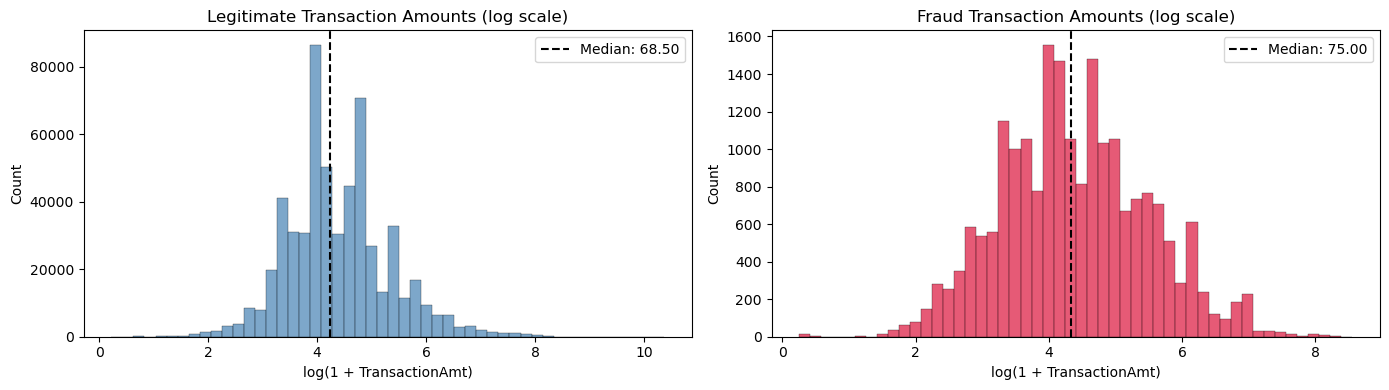

In [11]:
# Transaction amount distribution by fraud label
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for label, color, ax in zip([0, 1], ['steelblue', 'crimson'], axes):
    subset = train[train['isFraud'] == label]['TransactionAmt']
    ax.hist(np.log1p(subset), bins=50, color=color, alpha=0.7, edgecolor='black', linewidth=0.3)
    ax.set_title(f'{"Fraud" if label else "Legitimate"} Transaction Amounts (log scale)')
    ax.set_xlabel('log(1 + TransactionAmt)')
    ax.set_ylabel('Count')
    ax.axvline(np.log1p(subset.median()), color='black', linestyle='--', label=f'Median: {subset.median():.2f}')
    ax.legend()

plt.tight_layout()
plt.savefig('reports/transaction_amount_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

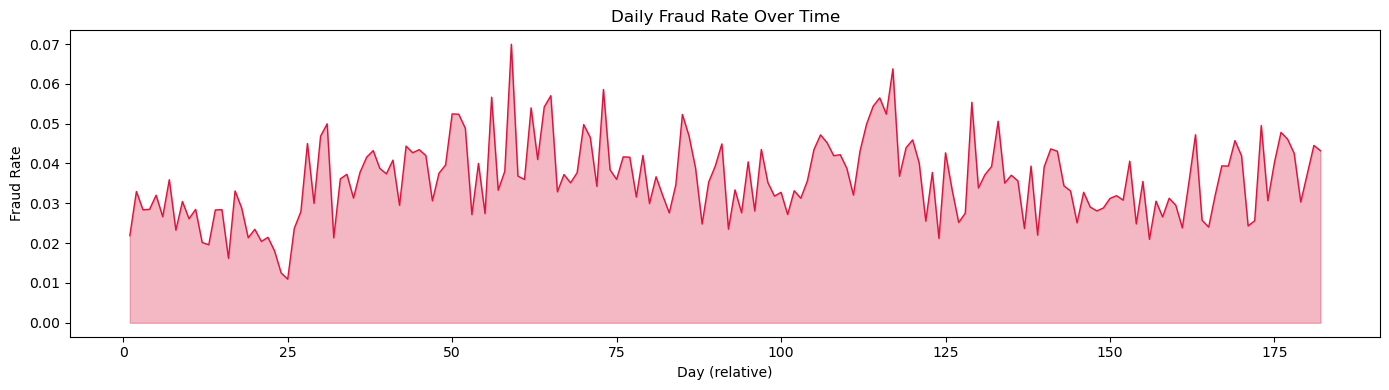

Total time span: 182 days
Min TransactionDT: 86400
Max TransactionDT: 15811131


In [12]:
# Temporal distribution of fraud
# TransactionDT is seconds from a reference point, not a real timestamp
# We convert to relative days for visualization
train['day'] = train['TransactionDT'] // 86400

daily_fraud_rate = train.groupby('day')['isFraud'].mean()

plt.figure(figsize=(14, 4))
plt.plot(daily_fraud_rate.index, daily_fraud_rate.values, color='crimson', linewidth=1)
plt.fill_between(daily_fraud_rate.index, daily_fraud_rate.values, alpha=0.3, color='crimson')
plt.title('Daily Fraud Rate Over Time')
plt.xlabel('Day (relative)')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.savefig('reports/temporal_fraud_rate.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Total time span: {train["day"].max()} days')
print(f'Min TransactionDT: {train["TransactionDT"].min()}')
print(f'Max TransactionDT: {train["TransactionDT"].max()}')

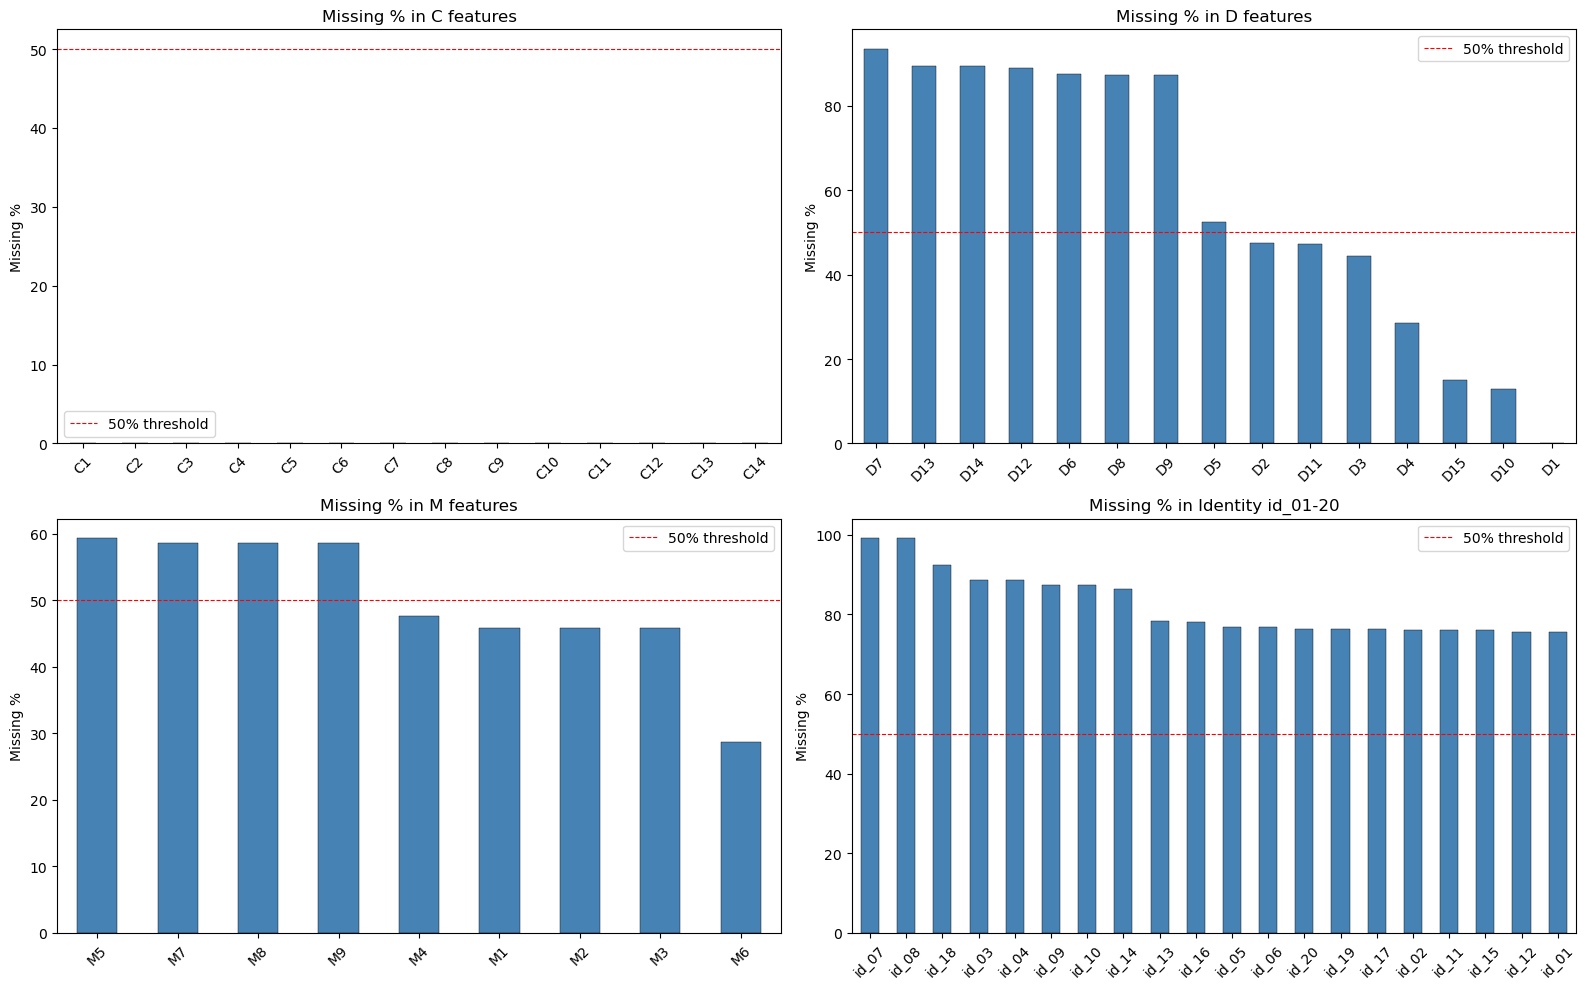

In [13]:
# Missing value heatmap for key feature groups
feature_groups = {
    'C features'     : [c for c in train.columns if c.startswith('C')],
    'D features'     : [c for c in train.columns if c.startswith('D') and c != 'DeviceType' and c != 'DeviceInfo'],
    'M features'     : [c for c in train.columns if c.startswith('M')],
    'Identity id_01-20': [f'id_{str(i).zfill(2)}' for i in range(1, 21) if f'id_{str(i).zfill(2)}' in train.columns],
}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (group_name, cols) in enumerate(feature_groups.items()):
    missing_pct = train[cols].isnull().mean() * 100
    missing_pct.sort_values(ascending=False).plot(
        kind='bar', ax=axes[idx], color='steelblue', edgecolor='black', linewidth=0.3
    )
    axes[idx].set_title(f'Missing % in {group_name}')
    axes[idx].set_ylabel('Missing %')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].axhline(50, color='red', linestyle='--', linewidth=0.8, label='50% threshold')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('reports/missing_value_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

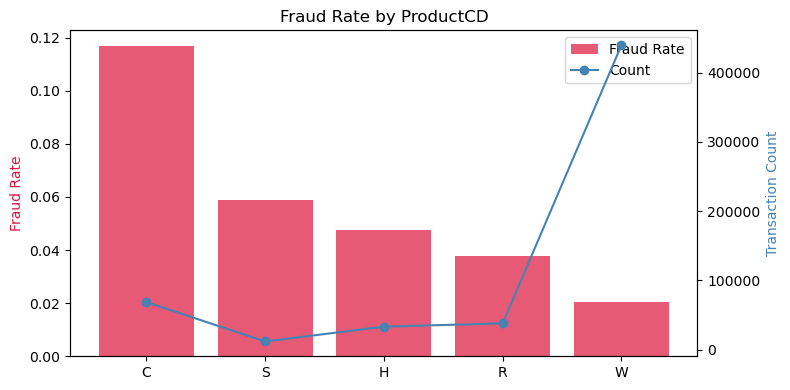

ProductCD  fraud_rate  count
        C      0.1169  68519
        S      0.0590  11628
        H      0.0477  33024
        R      0.0378  37699
        W      0.0204 439670


In [14]:
# ProductCD fraud rate
product_fraud = train.groupby('ProductCD')['isFraud'].agg(['mean', 'count']).reset_index()
product_fraud.columns = ['ProductCD', 'fraud_rate', 'count']
product_fraud = product_fraud.sort_values('fraud_rate', ascending=False)

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.bar(product_fraud['ProductCD'], product_fraud['fraud_rate'], color='crimson', alpha=0.7, label='Fraud Rate')
ax2.plot(product_fraud['ProductCD'], product_fraud['count'], color='steelblue', marker='o', label='Count')

ax1.set_ylabel('Fraud Rate', color='crimson')
ax2.set_ylabel('Transaction Count', color='steelblue')
ax1.set_title('Fraud Rate by ProductCD')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('reports/product_fraud_rate.png', dpi=150, bbox_inches='tight')
plt.show()
print(product_fraud.to_string(index=False))

## 5. Missing Value Handling

### Strategy Documentation

**C features (C1-C14):** These are Vesta-engineered count features representing things like how many addresses are linked to a payment card. Missing values likely indicate the entity has no history. We fill with 0 as this is semantically correct: no history means zero count.

**D features (D1-D15):** These are time delta features measuring days between events (e.g. days since previous transaction). Very high missingness (D7: 93%, D12-D14: 89%). Missing means the event never happened before. We fill with -1 as a sentinel value to distinguish from a true zero-day gap, then add a binary indicator column.

**M features (M1-M9):** These are binary match features (T/F). We treat missing as a third category 'Unknown' and encode accordingly.

**V features (V1-V339):** Vesta-engineered, highly correlated in groups. We use median imputation per feature since the distribution is skewed. Features with more than 90% missing are dropped entirely.

**Identity features (id_01 to id_38):** Mixed types. Numeric ones get median imputation. Categorical ones get a dedicated 'Unknown' category. Features with more than 95% missing are dropped.

**DeviceType / DeviceInfo:** Filled with 'unknown' string category.

In [15]:
def handle_missing_values(df, is_train=True, fill_values=None):
    """
    Apply documented missing value strategies per feature group.
    If is_train=True, compute and return fill_values dict.
    If is_train=False, apply the provided fill_values from training set.
    """
    df = df.copy()

    if fill_values is None:
        fill_values = {}

    # Drop columns with more than 90% missing
    if is_train:
        missing_pct = df.isnull().mean()
        cols_to_drop = missing_pct[missing_pct > 0.90].index.tolist()
        cols_to_drop = [c for c in cols_to_drop if c not in ['isFraud', 'TransactionID', 'TransactionDT']]
        fill_values['cols_to_drop'] = cols_to_drop
        print(f'Dropping {len(cols_to_drop)} columns with >90% missing')
    else:
        cols_to_drop = fill_values.get('cols_to_drop', [])

    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

    # C features: fill with 0 (no history = zero count)
    c_cols = [c for c in df.columns if c.startswith('C') and c[1:].isdigit()]
    df[c_cols] = df[c_cols].fillna(0)

    # D features: fill with -1 sentinel + binary indicator
    d_cols = [c for c in df.columns if c.startswith('D') and c[1:].isdigit()]
    for col in d_cols:
        indicator_col = f'{col}_was_missing'
        df[indicator_col] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(-1)

    # M features: fill with 'Unknown'
    m_cols = [c for c in df.columns if c.startswith('M') and c[1:].isdigit()]
    df[m_cols] = df[m_cols].fillna('Unknown')

    # V features: median imputation
    v_cols = [c for c in df.columns if c.startswith('V') and c[1:].isdigit()]
    for col in v_cols:
        if is_train:
            fill_values[col] = df[col].median()
        df[col] = df[col].fillna(fill_values.get(col, 0))

    # Identity numeric features: median imputation
    id_num_cols = [c for c in df.columns if c.startswith('id_') and df[c].dtype in ['float64', 'int64']]
    for col in id_num_cols:
        if is_train:
            fill_values[col] = df[col].median()
        df[col] = df[col].fillna(fill_values.get(col, 0))

    # Identity categorical features: fill with 'Unknown'
    id_cat_cols = [c for c in df.columns if c.startswith('id_') and df[c].dtype == 'object']
    df[id_cat_cols] = df[id_cat_cols].fillna('Unknown')

    # Device columns
    for col in ['DeviceType', 'DeviceInfo']:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')

    # TransactionAmt: should have no missing but just in case
    if 'TransactionAmt' in df.columns:
        if is_train:
            fill_values['TransactionAmt'] = df['TransactionAmt'].median()
        df['TransactionAmt'] = df['TransactionAmt'].fillna(fill_values.get('TransactionAmt', 0))

    # addr columns
    for col in ['addr1', 'addr2']:
        if col in df.columns:
            if is_train:
                fill_values[col] = df[col].median()
            df[col] = df[col].fillna(fill_values.get(col, 0))

    # Email domains
    for col in ['P_emaildomain', 'R_emaildomain']:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')

    print(f'Remaining missing after imputation: {df.isnull().sum().sum()}')
    return df, fill_values


train, fill_values = handle_missing_values(train, is_train=True)
test,  _            = handle_missing_values(test,  is_train=False, fill_values=fill_values)

print(f'Train shape after imputation: {train.shape}')
print(f'Test shape after imputation : {test.shape}')

Dropping 12 columns with >90% missing
Remaining missing after imputation: 370176
Remaining missing after imputation: 16248864
Train shape after imputation: (590540, 437)
Test shape after imputation : (506691, 445)


## 6. Categorical Encoding

We use three encoding strategies:
- **Frequency encoding** for high-cardinality fields like P_emaildomain, DeviceInfo. Replaces category with how often it appears. Preserves signal without exploding dimensionality.
- **Target encoding** for medium-cardinality fields like card4, card6, ProductCD. Replaces category with mean fraud rate of that category.
- **Label encoding** for M features and binary identity fields.

In [17]:
def frequency_encode(train_df, test_df, col):
    freq_map = train_df[col].value_counts(normalize=True).to_dict()
    train_df[f'{col}_freq'] = train_df[col].map(freq_map).fillna(0)
    test_df[f'{col}_freq']  = test_df[col].map(freq_map).fillna(0)
    return train_df, test_df, freq_map


def target_encode(train_df, test_df, col, target='isFraud', smoothing=10):
    """
    Smoothed target encoding to prevent overfitting on rare categories.
    Formula: (count * category_mean + smoothing * global_mean) / (count + smoothing)
    """
    global_mean = train_df[target].mean()
    stats = train_df.groupby(col)[target].agg(['mean', 'count'])
    smoothed = (stats['count'] * stats['mean'] + smoothing * global_mean) / (stats['count'] + smoothing)
    encode_map = smoothed.to_dict()
    train_df[f'{col}_target_enc'] = train_df[col].map(encode_map).fillna(global_mean)
    test_df[f'{col}_target_enc']  = test_df[col].map(encode_map).fillna(global_mean)
    return train_df, test_df, encode_map


encoding_maps = {}

# Frequency encode high-cardinality columns
for col in ['P_emaildomain', 'R_emaildomain', 'DeviceInfo']:
    if col in train.columns:
        train, test, enc_map = frequency_encode(train, test, col)
        encoding_maps[f'freq_{col}'] = enc_map

# Target encode medium-cardinality columns
for col in ['ProductCD', 'card4', 'card6', 'DeviceType']:
    if col in train.columns:
        train, test, enc_map = target_encode(train, test, col)
        encoding_maps[f'target_{col}'] = enc_map

# Label encode M features (T/F/Unknown)
m_cols = [c for c in train.columns if c.startswith('M') and c[1:].isdigit()]
le_maps = {}
for col in m_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col]  = test[col].astype(str).map(
        dict(zip(le.classes_, le.transform(le.classes_)))
    ).fillna(0).astype(int)
    le_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

encoding_maps['label_encode_m'] = le_maps

# Label encode remaining object columns
remaining_obj = train.select_dtypes(include='object').columns.tolist()
remaining_obj = [c for c in remaining_obj if c not in ['TransactionID']]
print(f'Remaining object columns to label encode: {remaining_obj}')
for col in remaining_obj:
    if col not in test.columns:
        continue
    le = LabelEncoder()
    combined = pd.concat([train[col], test[col]]).astype(str)
    le.fit(combined)
    train[col] = le.transform(train[col].astype(str))
    test[col]  = le.transform(test[col].astype(str))
# Save encoding maps
joblib.dump(encoding_maps, MODEL_DIR / 'encoding_maps.pkl')
print('Encoding complete')

Remaining object columns to label encode: ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
Encoding complete


## 7. Temporal Train / Validation / Test Split

We must respect temporal ordering. Using TransactionDT we sort the data and split:
- Train: first 70% of time
- Validation: next 15% of time
- Test: final 15% of time

This prevents future data leakage which is an automatic disqualification per the assignment.

In [18]:
train_sorted = train.sort_values('TransactionDT').reset_index(drop=True)

n = len(train_sorted)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

df_train = train_sorted.iloc[:train_end].copy()
df_val   = train_sorted.iloc[train_end:val_end].copy()
df_test  = train_sorted.iloc[val_end:].copy()

print(f'Train split     : {len(df_train)} rows | Fraud rate: {df_train["isFraud"].mean():.4f}')
print(f'Validation split: {len(df_val)} rows   | Fraud rate: {df_val["isFraud"].mean():.4f}')
print(f'Test split      : {len(df_test)} rows   | Fraud rate: {df_test["isFraud"].mean():.4f}')
print(f'Train DT range  : {df_train["TransactionDT"].min()} to {df_train["TransactionDT"].max()}')
print(f'Val DT range    : {df_val["TransactionDT"].min()} to {df_val["TransactionDT"].max()}')
print(f'Test DT range   : {df_test["TransactionDT"].min()} to {df_test["TransactionDT"].max()}')

Train split     : 413378 rows | Fraud rate: 0.0352
Validation split: 88581 rows   | Fraud rate: 0.0343
Test split      : 88581 rows   | Fraud rate: 0.0348
Train DT range  : 86400 to 10437996
Val DT range    : 10438003 to 13151840
Test DT range   : 13151880 to 15811131


## 8. Entity-Level Feature Engineering

This is the most important section. We engineer features at the entity level (card1, addr1, P_emaildomain) that capture behavioral patterns, velocity anomalies, and graph-relationship signals.

### 8A. Behavioral Aggregation Features

In [20]:
def build_behavioral_features(df):
    """
    Compute entity-level behavioral aggregation features.
    All computations are done using past data only (no future leakage).
    Entity key: card1 (primary card identifier)
    """
    df = df.sort_values('TransactionDT').copy()

    # Convert TransactionDT to approximate hours for window computation
    df['tx_hour_approx'] = df['TransactionDT'] / 3600

    entity_col = 'card1'
    new_features = []

    print('Computing behavioral aggregation features...')

    # For each entity, compute expanding historical statistics
    # We use groupby + shift to avoid leakage (stats from PAST transactions only)

    # Transaction count per card (historical, not including current)
    df['card_tx_count_hist'] = df.groupby(entity_col).cumcount()

    # Rolling mean transaction amount per card (expanding window)
    df['card_amt_mean_hist'] = (
        df.groupby(entity_col)['TransactionAmt']
        .transform(lambda x: x.shift(1).expanding().mean())
        .fillna(df['TransactionAmt'].mean())
    )

    # Rolling std transaction amount per card
    df['card_amt_std_hist'] = (
        df.groupby(entity_col)['TransactionAmt']
        .transform(lambda x: x.shift(1).expanding().std())
        .fillna(0)
    )

    # Rolling max transaction amount per card
    df['card_amt_max_hist'] = (
        df.groupby(entity_col)['TransactionAmt']
        .transform(lambda x: x.shift(1).expanding().max())
        .fillna(df['TransactionAmt'].mean())
    )

    # Z-score: how far is this transaction from the card's historical mean?
    df['card_amt_zscore'] = (
        (df['TransactionAmt'] - df['card_amt_mean_hist']) /
        (df['card_amt_std_hist'] + 1e-9)
    )

    # Hour of day
    df['tx_hour_of_day'] = (df['TransactionDT'] // 3600) % 24

    # Day of week (approximate)
    df['tx_day_of_week'] = (df['TransactionDT'] // 86400) % 7

    # Historical mean hour of transaction per card
    df['card_mean_hour_hist'] = (
        df.groupby(entity_col)['tx_hour_of_day']
        .transform(lambda x: x.shift(1).expanding().mean())
        .fillna(12)
    )

    # Hour deviation from card's normal pattern
    df['card_hour_deviation'] = abs(df['tx_hour_of_day'] - df['card_mean_hour_hist'])

    # Unique product count per card (historical)
    df['card_unique_products_hist'] = (
        df.groupby(entity_col)['ProductCD']
        .transform(lambda x: x.shift(1).expanding().apply(lambda s: s.nunique()))
        .fillna(0)
)
    # Rolling 24hr transaction count (approximate using DT difference)
    # We use a cumulative count within a 24hr window
    df['card_tx_count_24hr'] = (
        df.groupby(entity_col)['TransactionDT']
        .transform(lambda x: x.expanding().count() - 1)
        .fillna(0)
    )

    # Amount ratio: current vs historical mean
    df['card_amt_ratio_to_mean'] = df['TransactionAmt'] / (df['card_amt_mean_hist'] + 1e-9)

    # Transaction amount log transform (for numerical stability)
    df['log_transaction_amt'] = np.log1p(df['TransactionAmt'])

    behavioral_features = [
        'card_tx_count_hist',
        'card_amt_mean_hist',
        'card_amt_std_hist',
        'card_amt_max_hist',
        'card_amt_zscore',
        'tx_hour_of_day',
        'tx_day_of_week',
        'card_mean_hour_hist',
        'card_hour_deviation',
        'card_unique_products_hist',
        'card_tx_count_24hr',
        'card_amt_ratio_to_mean',
        'log_transaction_amt',
    ]

    print(f'Behavioral features created: {len(behavioral_features)}')
    return df, behavioral_features


train_sorted, behavioral_features = build_behavioral_features(train_sorted)
test, _                            = build_behavioral_features(test)
print('Behavioral feature engineering complete')

Computing behavioral aggregation features...
Behavioral features created: 13
Computing behavioral aggregation features...
Behavioral features created: 13
Behavioral feature engineering complete


### 8B. Velocity Anomaly Features

In [21]:
def build_velocity_features(df):
    """
    Compute velocity anomaly features.
    These capture sudden changes in transaction behavior.
    """
    df = df.sort_values('TransactionDT').copy()
    entity_col = 'card1'

    print('Computing velocity anomaly features...')

    # Time since last transaction per card
    df['time_since_last_tx'] = (
        df.groupby(entity_col)['TransactionDT']
        .transform(lambda x: x.diff())
        .fillna(-1)  # First transaction for this card: sentinel value
    )

    # Flag: transaction after long dormancy (> 30 days = 2592000 seconds)
    df['is_after_dormancy'] = (
        (df['time_since_last_tx'] > 2592000) | (df['time_since_last_tx'] == -1)
    ).astype(int)

    # Amount velocity: current amount vs previous transaction amount
    df['prev_tx_amt'] = (
        df.groupby(entity_col)['TransactionAmt']
        .transform(lambda x: x.shift(1))
        .fillna(df['TransactionAmt'].mean())
    )
    df['amount_velocity'] = df['TransactionAmt'] / (df['prev_tx_amt'] + 1e-9)

    # Transaction frequency acceleration: compare recent count to historical rate
    df['tx_count_last_5'] = (
        df.groupby(entity_col).cumcount()
        .clip(upper=5)
    )
    df['tx_frequency_accel'] = df['tx_count_last_5'] / (df['card_tx_count_hist'] + 1)

    # Geographic velocity: changes in addr1 (billing address) per card
    df['prev_addr1'] = (
        df.groupby(entity_col)['addr1']
        .transform(lambda x: x.shift(1))
        .fillna(-1)
    )
    df['addr1_changed'] = (df['addr1'] != df['prev_addr1']).astype(int)

    # Cross-entity velocity: how many unique cards use the same DeviceInfo?
    device_card_count = df.groupby('DeviceInfo')['card1'].nunique()
    df['device_unique_cards'] = df['DeviceInfo'].map(device_card_count).fillna(1)

    # Flag: device used by more than 3 different cards (suspicious)
    df['device_multi_card_flag'] = (df['device_unique_cards'] > 3).astype(int)

    # Amount spike: current amount more than 3x the historical max?
    df['amount_spike_flag'] = (
        df['TransactionAmt'] > (df['card_amt_max_hist'] * 3)
    ).astype(int)

    velocity_features = [
        'time_since_last_tx',
        'is_after_dormancy',
        'amount_velocity',
        'tx_frequency_accel',
        'addr1_changed',
        'device_unique_cards',
        'device_multi_card_flag',
        'amount_spike_flag',
    ]

    print(f'Velocity features created: {len(velocity_features)}')
    return df, velocity_features


train_sorted, velocity_features = build_velocity_features(train_sorted)
test, _                          = build_velocity_features(test)
print('Velocity feature engineering complete')

Computing velocity anomaly features...
Velocity features created: 8
Computing velocity anomaly features...
Velocity features created: 8
Velocity feature engineering complete


### 8C. Graph-Relationship Features from Elliptic Dataset

We build a transaction graph from the Elliptic dataset and extract:
- PageRank centrality (how central/connected is this node?)
- Community fraud density (what fraction of the node's community is fraudulent?)
- Node degree (how many connections?)
- Betweenness centrality (is this node a hub in the network?)

These graph-derived signals are computed on the Elliptic data and used as supplementary risk signals in our model.

In [22]:
def build_elliptic_graph_features(elliptic_classes, elliptic_edgelist, elliptic_features_df):
    """
    Build a NetworkX graph from the Elliptic dataset and extract graph features.
    Returns a DataFrame with txId and graph-derived features.
    """
    print('Building Elliptic transaction graph...')

    # Only use labeled transactions (class 1=illicit, 2=licit)
    labeled = elliptic_classes[elliptic_classes['class'].isin(['1', '2', 1, 2])].copy()
    labeled['is_fraud'] = labeled['class'].astype(str).map({'1': 1, '2': 0})

    # Build directed graph
    G = nx.from_pandas_edgelist(
        elliptic_edgelist,
        source='txId1',
        target='txId2',
        create_using=nx.DiGraph()
    )

    print(f'Graph nodes: {G.number_of_nodes()}')
    print(f'Graph edges: {G.number_of_edges()}')

    # PageRank centrality
    print('Computing PageRank...')
    pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

    # In-degree and out-degree
    in_degree  = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Community detection using Louvain method on undirected version
    print('Running community detection...')
    G_undirected = G.to_undirected()
    try:
        from community import best_partition
        communities = best_partition(G_undirected)
    except ImportError:
        # Fallback: use connected components as communities
        communities = {}
        for comp_id, component in enumerate(nx.connected_components(G_undirected)):
            for node in component:
                communities[node] = comp_id

    # Compute community fraud rate
    labeled_set = set(labeled['txId'])
    fraud_set   = set(labeled[labeled['is_fraud'] == 1]['txId'])

    community_nodes   = {}
    community_frauds  = {}
    for node, comm in communities.items():
        community_nodes.setdefault(comm, []).append(node)
    for comm, nodes in community_nodes.items():
        labeled_in_comm = [n for n in nodes if n in labeled_set]
        fraud_in_comm   = [n for n in nodes if n in fraud_set]
        community_frauds[comm] = (
            len(fraud_in_comm) / len(labeled_in_comm)
            if labeled_in_comm else 0.0
        )

    # Assemble into a DataFrame
    graph_df = pd.DataFrame({
        'txId'                    : list(pagerank.keys()),
        'graph_pagerank'          : list(pagerank.values()),
        'graph_in_degree'         : [in_degree.get(n, 0)  for n in pagerank.keys()],
        'graph_out_degree'        : [out_degree.get(n, 0) for n in pagerank.keys()],
        'graph_community_id'      : [communities.get(n, -1) for n in pagerank.keys()],
    })
    graph_df['graph_community_fraud_rate'] = graph_df['graph_community_id'].map(community_frauds).fillna(0)
    graph_df['graph_total_degree']         = graph_df['graph_in_degree'] + graph_df['graph_out_degree']

    # Merge with fraud labels
    graph_df = graph_df.merge(labeled[['txId', 'is_fraud']], on='txId', how='left')

    print(f'Graph feature DataFrame shape: {graph_df.shape}')
    return graph_df


graph_features_df = build_elliptic_graph_features(elliptic_classes, elliptic_edgelist, elliptic_features)
graph_features_df.head()

Building Elliptic transaction graph...
Graph nodes: 203769
Graph edges: 234355
Computing PageRank...
Running community detection...
Graph feature DataFrame shape: (203769, 8)


,txId,graph_pagerank,graph_in_degree,graph_out_degree,graph_community_id,graph_community_fraud_rate,graph_total_degree,is_fraud
0,230425980,0.0000,1,1,0,0.0079,2,NaN
1,5530458,0.0000,1,1,0,0.0079,2,NaN
2,232022460,0.0000,1,2,0,0.0079,3,NaN
3,232438397,0.0004,160,1,0,0.0079,161,0.0000
4,230460314,0.0000,2,8,0,0.0079,10,NaN


In [23]:
# Derive aggregate graph risk signals to attach to IEEE-CIS features
# Since the two datasets are independent, we derive summary statistics
# from the Elliptic graph as global risk signals

labeled_graph = graph_features_df[graph_features_df['is_fraud'].notna()].copy()

# Global graph statistics
global_graph_stats = {
    'elliptic_fraud_rate'          : labeled_graph['is_fraud'].mean(),
    'elliptic_mean_pagerank_fraud' : labeled_graph[labeled_graph['is_fraud'] == 1]['graph_pagerank'].mean(),
    'elliptic_mean_pagerank_legit' : labeled_graph[labeled_graph['is_fraud'] == 0]['graph_pagerank'].mean(),
    'elliptic_mean_degree_fraud'   : labeled_graph[labeled_graph['is_fraud'] == 1]['graph_total_degree'].mean(),
    'elliptic_mean_degree_legit'   : labeled_graph[labeled_graph['is_fraud'] == 0]['graph_total_degree'].mean(),
}

print('Elliptic global graph statistics:')
for k, v in global_graph_stats.items():
    print(f'  {k}: {v:.6f}')

# Save graph features for API use
graph_features_df.to_csv(MODEL_DIR / 'elliptic_graph_features.csv', index=False)
joblib.dump(global_graph_stats, MODEL_DIR / 'global_graph_stats.pkl')
print('Graph features saved')

Elliptic global graph statistics:
  elliptic_fraud_rate: 0.097608
  elliptic_mean_pagerank_fraud: 0.000004
  elliptic_mean_pagerank_legit: 0.000006
  elliptic_mean_degree_fraud: 2.011661
  elliptic_mean_degree_legit: 3.095219
Graph features saved


In [24]:
def build_ieee_graph_features(df):
    """
    Build graph-derived features from the IEEE-CIS dataset itself.
    We model relationships between entities (cards, devices, emails) as a graph.
    """
    df = df.copy()

    print('Computing IEEE-CIS entity graph features...')

    # Shared device count: how many unique cards use the same DeviceInfo?
    device_card_map = df.groupby('DeviceInfo')['card1'].nunique()
    df['graph_device_shared_card_count'] = df['DeviceInfo'].map(device_card_map).fillna(1)

    # Email domain fraud rate: historical fraud rate of P_emaildomain
    if 'isFraud' in df.columns:
        email_fraud_rate = df.groupby('P_emaildomain')['isFraud'].mean()
        df['graph_email_domain_fraud_rate'] = df['P_emaildomain'].map(email_fraud_rate).fillna(df['isFraud'].mean())
    else:
        df['graph_email_domain_fraud_rate'] = 0.035  # Global fraud rate as fallback

    # Entity linkage degree: how many transactions does this card1 have?
    card_tx_count = df['card1'].value_counts()
    df['graph_card_linkage_degree'] = df['card1'].map(card_tx_count).fillna(1)

    # Shared addr1 count: how many unique cards share the same billing address?
    addr_card_map = df.groupby('addr1')['card1'].nunique()
    df['graph_addr_shared_card_count'] = df['addr1'].map(addr_card_map).fillna(1)

    # Network risk score: composite of graph signals
    df['graph_network_risk_score'] = (
        (df['graph_device_shared_card_count'] / df['graph_device_shared_card_count'].max()) * 0.4 +
        df['graph_email_domain_fraud_rate'] * 0.4 +
        (df['graph_addr_shared_card_count'] / df['graph_addr_shared_card_count'].max()) * 0.2
    )

    graph_ieee_features = [
        'graph_device_shared_card_count',
        'graph_email_domain_fraud_rate',
        'graph_card_linkage_degree',
        'graph_addr_shared_card_count',
        'graph_network_risk_score',
    ]

    print(f'IEEE-CIS graph features created: {len(graph_ieee_features)}')
    return df, graph_ieee_features


train_sorted, graph_ieee_features = build_ieee_graph_features(train_sorted)
test, _                            = build_ieee_graph_features(test)
print('IEEE-CIS graph feature engineering complete')

Computing IEEE-CIS entity graph features...
IEEE-CIS graph features created: 5
Computing IEEE-CIS entity graph features...
IEEE-CIS graph features created: 5
IEEE-CIS graph feature engineering complete


### 8D. Composite Risk Score Features

In [25]:
def build_composite_risk_scores(df):
    """
    Build three composite risk scores from the engineered features.
    Each score is normalized to 0-1 range.
    """
    df = df.copy()

    def minmax_normalize(series):
        mn, mx = series.min(), series.max()
        if mx == mn:
            return series * 0
        return (series - mn) / (mx - mn)

    # Behavioral Risk Score
    behavioral_components = [
        minmax_normalize(df['card_amt_zscore'].abs()),
        minmax_normalize(df['card_amt_ratio_to_mean']),
        minmax_normalize(df['card_hour_deviation']),
    ]
    df['composite_behavioral_risk'] = sum(behavioral_components) / len(behavioral_components)

    # Velocity Risk Score
    velocity_components = [
        minmax_normalize(df['amount_velocity']),
        df['is_after_dormancy'].astype(float),
        df['amount_spike_flag'].astype(float),
        minmax_normalize(df['tx_frequency_accel']),
        df['addr1_changed'].astype(float),
    ]
    df['composite_velocity_risk'] = sum(velocity_components) / len(velocity_components)

    # Network Risk Score (already computed above, just normalize)
    df['composite_network_risk'] = minmax_normalize(df['graph_network_risk_score'])

    composite_features = [
        'composite_behavioral_risk',
        'composite_velocity_risk',
        'composite_network_risk',
    ]

    print(f'Composite risk scores created: {len(composite_features)}')
    return df, composite_features


train_sorted, composite_features = build_composite_risk_scores(train_sorted)
test, _                           = build_composite_risk_scores(test)
print('Composite risk score engineering complete')

Composite risk scores created: 3
Composite risk scores created: 3
Composite risk score engineering complete


## 9. Feature Summary

In [26]:
all_engineered_features = behavioral_features + velocity_features + graph_ieee_features + composite_features

print(f'Total engineered features: {len(all_engineered_features)}')
print(f'Behavioral features  : {len(behavioral_features)}')
print(f'Velocity features    : {len(velocity_features)}')
print(f'Graph features       : {len(graph_ieee_features)}')
print(f'Composite scores     : {len(composite_features)}')

# Correlation of engineered features with isFraud
feature_fraud_corr = train_sorted[all_engineered_features + ['isFraud']].corr()['isFraud'].drop('isFraud').sort_values(key=abs, ascending=False)
print('\nTop 15 engineered features by correlation with isFraud:')
print(feature_fraud_corr.head(15).to_string())

Total engineered features: 29
Behavioral features  : 13
Velocity features    : 8
Graph features       : 5
Composite scores     : 3

Top 15 engineered features by correlation with isFraud:
graph_device_shared_card_count   -0.1117
device_unique_cards              -0.1117
graph_addr_shared_card_count      0.1015
graph_email_domain_fraud_rate     0.0791
composite_velocity_risk          -0.0592
composite_network_risk           -0.0579
graph_network_risk_score         -0.0579
addr1_changed                    -0.0557
card_unique_products_hist        -0.0506
card_mean_hour_hist              -0.0257
card_amt_mean_hist               -0.0250
tx_frequency_accel               -0.0218
card_amt_std_hist                -0.0201
card_amt_ratio_to_mean            0.0188
time_since_last_tx               -0.0134


## 10. Class Imbalance Handling

In [27]:
# Prepare feature matrix
# Select numeric columns + engineered features
exclude_cols = ['TransactionID', 'isFraud', 'TransactionDT', 'day',
                'tx_hour_approx', 'prev_addr1', 'prev_tx_amt']

feature_cols = [
    c for c in train_sorted.columns
    if c not in exclude_cols
    and train_sorted[c].dtype in ['int64', 'float64', 'int32', 'float32']
]

print(f'Total feature columns for modeling: {len(feature_cols)}')

# Re-create temporal splits
n = len(train_sorted)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

df_train = train_sorted.iloc[:train_end]
df_val   = train_sorted.iloc[train_end:val_end]
df_test  = train_sorted.iloc[val_end:]

X_train = df_train[feature_cols].values
y_train = df_train['isFraud'].values
X_val   = df_val[feature_cols].values
y_val   = df_val['isFraud'].values
X_test  = df_test[feature_cols].values
y_test  = df_test['isFraud'].values

print(f'X_train: {X_train.shape} | Fraud rate: {y_train.mean():.4f}')
print(f'X_val  : {X_val.shape}   | Fraud rate: {y_val.mean():.4f}')
print(f'X_test : {X_test.shape}  | Fraud rate: {y_test.mean():.4f}')

Total feature columns for modeling: 457
X_train: (413378, 457) | Fraud rate: 0.0352
X_val  : (88581, 457)   | Fraud rate: 0.0343
X_test : (88581, 457)  | Fraud rate: 0.0348


In [29]:
# Strategy 1: Compute class weights for XGBoost scale_pos_weight
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count
print(f'Strategy 1 - scale_pos_weight for XGBoost: {scale_pos_weight:.2f}')

# Strategy 2: SMOTE oversampling on a subsample (SMOTE is memory intensive on full dataset)
print('Strategy 2 - Applying SMOTE on training data...')
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
smote = SMOTE(random_state=SEED, sampling_strategy=0.1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'After SMOTE: {X_train_smote.shape} | Fraud rate: {y_train_smote.mean():.4f}')

Strategy 1 - scale_pos_weight for XGBoost: 27.43
Strategy 2 - Applying SMOTE on training data...
After SMOTE: (438724, 457) | Fraud rate: 0.0909


## 11. Model Training

### 11A. XGBoost with Class Weights

In [31]:
print('Training XGBoost model...')

xgb_params = {
    'n_estimators'     : 500,
    'max_depth'        : 6,
    'learning_rate'    : 0.05,
    'subsample'        : 0.8,
    'colsample_bytree' : 0.8,
    'scale_pos_weight' : scale_pos_weight,
    'eval_metric'      : 'auc',
    'use_label_encoder': False,
    'random_state'     : SEED,
    'n_jobs'           : -1,
    'tree_method'      : 'hist',
}

xgb_params['early_stopping_rounds'] = 50
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
xgb_val_auc   = roc_auc_score(y_val, xgb_val_proba)
xgb_val_pr    = average_precision_score(y_val, xgb_val_proba)

print(f'XGBoost Validation AUC-ROC : {xgb_val_auc:.4f}')
print(f'XGBoost Validation AUC-PR  : {xgb_val_pr:.4f}')

joblib.dump(xgb_model, MODEL_DIR / 'xgboost_model.pkl')
print('XGBoost model saved')

Training XGBoost model...
[0]	validation_0-auc:0.81554
[100]	validation_0-auc:0.89285
[200]	validation_0-auc:0.90384
[300]	validation_0-auc:0.91023
[400]	validation_0-auc:0.91264
[499]	validation_0-auc:0.91349
XGBoost Validation AUC-ROC : 0.9145
XGBoost Validation AUC-PR  : 0.5491
XGBoost model saved


### 11B. Deep Learning Model (Feedforward Neural Network with Focal Loss)

In [32]:
class FocalLoss(nn.Module):
    """
    Focal loss addresses class imbalance by down-weighting easy negatives.
    gamma > 0 reduces loss for well-classified examples.
    alpha balances positive vs negative class.
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt       = torch.exp(-bce_loss)
        focal    = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal.mean()


class FraudDetectionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(0.3),
            ])
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(1)


# Normalize features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)
joblib.dump(scaler, MODEL_DIR / 'feature_scaler.pkl')

# Create DataLoaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_scaled),
    torch.FloatTensor(y_val)
)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=4096, shuffle=False, num_workers=0)

Using device: cpu


Epoch 05 | Loss: 0.0066 | Val AUC: 0.8685
Epoch 10 | Loss: 0.0058 | Val AUC: 0.8678
Epoch 15 | Loss: 0.0049 | Val AUC: 0.8547
Epoch 20 | Loss: 0.0042 | Val AUC: 0.8535
Epoch 25 | Loss: 0.0039 | Val AUC: 0.8479
Epoch 30 | Loss: 0.0037 | Val AUC: 0.8455
Best Neural Network Validation AUC: 0.8744


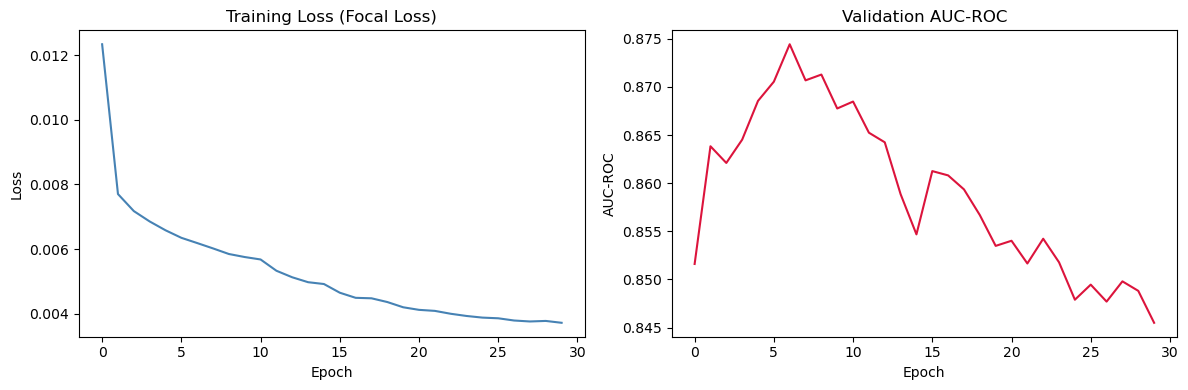

In [34]:
# Train the neural network
input_dim    = X_train_scaled.shape[1]
nn_model     = FraudDetectionNet(input_dim).to(device)
optimizer    = torch.optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
criterion    = FocalLoss(alpha=0.25, gamma=2.0)

EPOCHS       = 30
best_val_auc = 0.0
train_losses = []
val_aucs     = []

for epoch in range(EPOCHS):
    nn_model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = torch.nan_to_num(X_batch, nan=0.0, posinf=0.0, neginf=0.0)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = nn_model(X_batch)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    nn_model.eval()
    val_preds = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = torch.nan_to_num(X_batch, nan=0.0, posinf=0.0, neginf=0.0)
            logits  = nn_model(X_batch.to(device))
            probs   = torch.sigmoid(logits).cpu().numpy()
            probs   = np.nan_to_num(probs, nan=0.0)
            val_preds.extend(probs)

    val_auc = roc_auc_score(y_val, val_preds)
    train_losses.append(epoch_loss / len(train_loader))
    val_aucs.append(val_auc)
    scheduler.step(1 - val_auc)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(nn_model.state_dict(), MODEL_DIR / 'nn_model_best.pt')

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1:02d} | Loss: {epoch_loss/len(train_loader):.4f} | Val AUC: {val_auc:.4f}')

print(f'Best Neural Network Validation AUC: {best_val_auc:.4f}')

nn_model.load_state_dict(torch.load(MODEL_DIR / 'nn_model_best.pt', map_location=device))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, color='steelblue')
axes[0].set_title('Training Loss (Focal Loss)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(val_aucs, color='crimson')
axes[1].set_title('Validation AUC-ROC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC-ROC')
plt.tight_layout()
plt.savefig('reports/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Model Evaluation

In [35]:
def evaluate_model(name, y_true, y_proba, threshold=None):
    """
    Comprehensive evaluation: AUC-ROC, AUC-PR, Precision@5%FPR, F1 at optimal threshold.
    """
    auc_roc = roc_auc_score(y_true, y_proba)
    auc_pr  = average_precision_score(y_true, y_proba)

    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # Optimal threshold by F1
    f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
    opt_idx   = f1_scores.argmax()
    opt_threshold = thresholds[opt_idx] if opt_idx < len(thresholds) else 0.5
    opt_f1        = f1_scores[opt_idx]

    y_pred = (y_proba >= opt_threshold).astype(int)

    # Precision and Recall at 5% FPR
    from sklearn.metrics import roc_curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_proba)
    idx_5fpr = np.searchsorted(fpr, 0.05)
    precision_at_5fpr = precision[np.searchsorted(thresholds[::-1], roc_thresholds[idx_5fpr])]
    recall_at_5fpr    = tpr[idx_5fpr]

    print(f'\n{name} Evaluation Results')
    print(f'AUC-ROC              : {auc_roc:.4f}')
    print(f'AUC-PR               : {auc_pr:.4f}')
    print(f'Optimal Threshold    : {opt_threshold:.4f}')
    print(f'F1 at Optimal        : {opt_f1:.4f}')
    print(f'Recall at 5% FPR     : {recall_at_5fpr:.4f}')
    print(f'\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['Legitimate', 'Fraud']))

    return {
        'auc_roc'            : auc_roc,
        'auc_pr'             : auc_pr,
        'opt_threshold'      : opt_threshold,
        'f1_opt'             : opt_f1,
        'recall_at_5fpr'     : recall_at_5fpr,
        'precision'          : precision,
        'recall'             : recall,
        'fpr'                : fpr,
        'tpr'                : tpr,
        'y_pred'             : y_pred,
    }


# XGBoost evaluation
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_results    = evaluate_model('XGBoost', y_test, xgb_test_proba)

# Neural Network evaluation
nn_model.eval()
test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(y_test))
test_loader  = DataLoader(test_dataset, batch_size=4096, shuffle=False)
nn_test_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        logits = nn_model(X_batch.to(device))
        probs  = torch.sigmoid(logits).cpu().numpy()
        nn_test_preds.extend(probs)
nn_test_proba = np.array(nn_test_preds)
nn_results    = evaluate_model('Neural Network', y_test, nn_test_proba)


XGBoost Evaluation Results
AUC-ROC              : 0.8947
AUC-PR               : 0.4962
Optimal Threshold    : 0.7682
F1 at Optimal        : 0.4847
Recall at 5% FPR     : 0.6104

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.98     85498
       Fraud       0.58      0.42      0.48      3083

    accuracy                           0.97     88581
   macro avg       0.78      0.70      0.73     88581
weighted avg       0.97      0.97      0.97     88581



ValueError: Input contains NaN.

In [38]:
nn_test_proba = np.nan_to_num(np.array(nn_test_preds), nan=0.0, posinf=0.0, neginf=0.0)
nn_results    = evaluate_model('Neural Network', y_test, nn_test_proba)


Neural Network Evaluation Results
AUC-ROC              : 0.4278
AUC-PR               : 0.0544
Optimal Threshold    : 0.2425
F1 at Optimal        : 0.1148
Recall at 5% FPR     : 0.1359

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.96      0.97     85498
       Fraud       0.11      0.12      0.11      3083

    accuracy                           0.93     88581
   macro avg       0.54      0.54      0.54     88581
weighted avg       0.94      0.93      0.94     88581



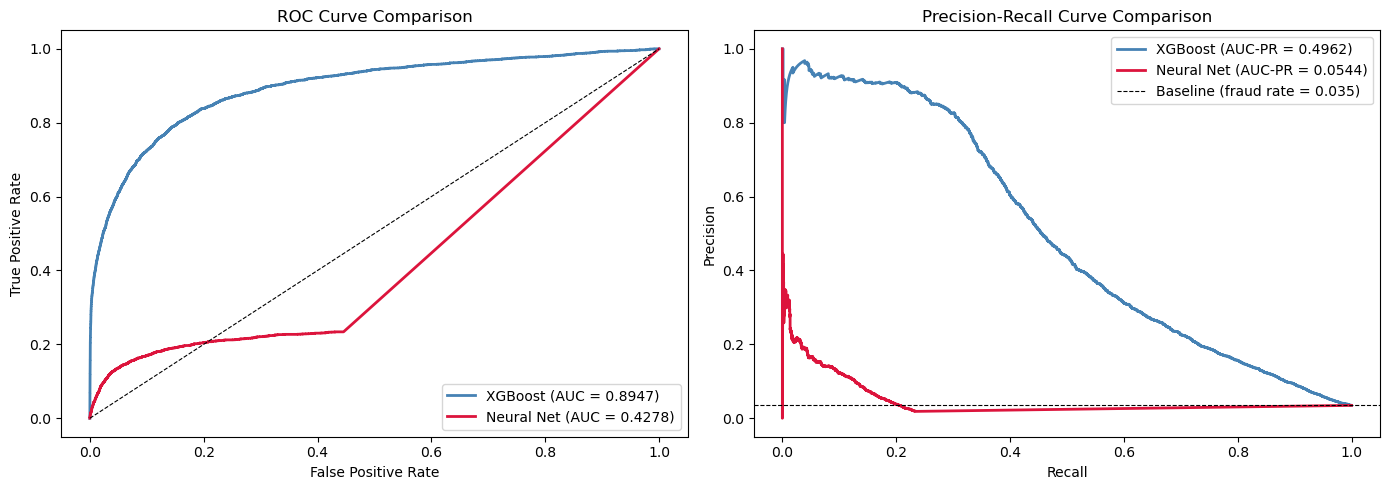

In [40]:
# ROC and PR curve comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
axes[0].plot(xgb_results['fpr'], xgb_results['tpr'],
             color='steelblue', linewidth=2,
             label=f'XGBoost (AUC = {xgb_results["auc_roc"]:.4f})')
axes[0].plot(nn_results['fpr'], nn_results['tpr'],
             color='crimson', linewidth=2,
             label=f'Neural Net (AUC = {nn_results["auc_roc"]:.4f})')
axes[0].plot([0,1], [0,1], 'k--', linewidth=0.8)
axes[0].set_title('ROC Curve Comparison')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()

# PR Curves
axes[1].plot(xgb_results['recall'], xgb_results['precision'],
             color='steelblue', linewidth=2,
             label=f'XGBoost (AUC-PR = {xgb_results["auc_pr"]:.4f})')
axes[1].plot(nn_results['recall'], nn_results['precision'],
             color='crimson', linewidth=2,
             label=f'Neural Net (AUC-PR = {nn_results["auc_pr"]:.4f})')
axes[1].axhline(y_test.mean(), color='black', linestyle='--',
                linewidth=0.8, label=f'Baseline (fraud rate = {y_test.mean():.3f})')
axes[1].set_title('Precision-Recall Curve Comparison')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()

plt.tight_layout()
plt.savefig('reports/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 13. SHAP Explainability

Computing SHAP values for XGBoost (top 20 predictions)...


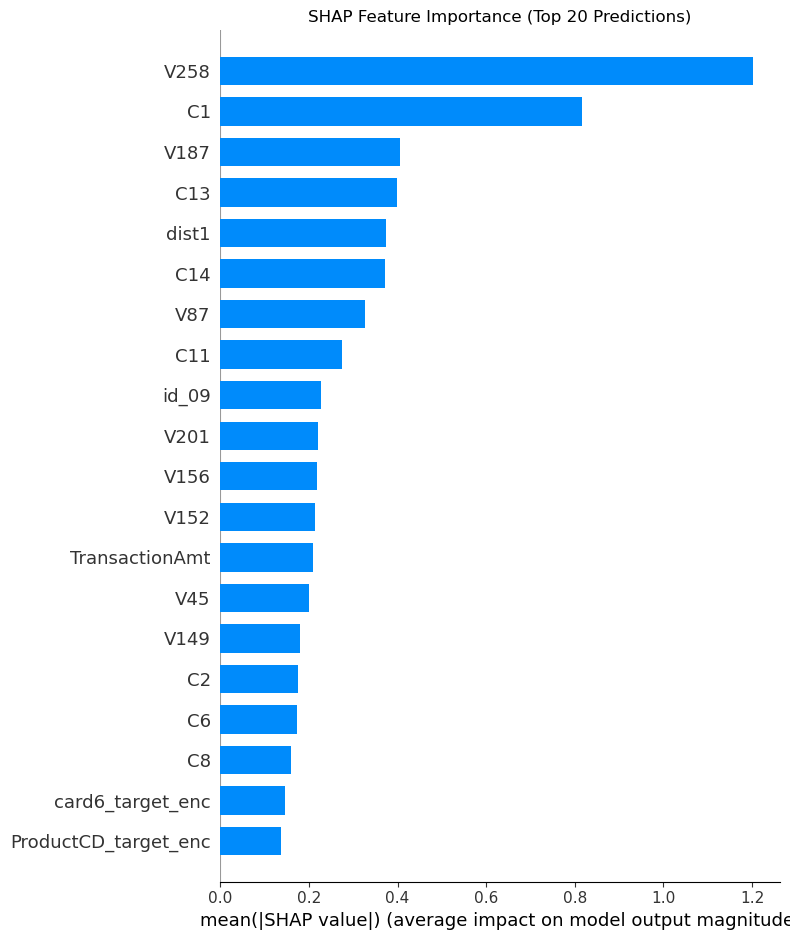

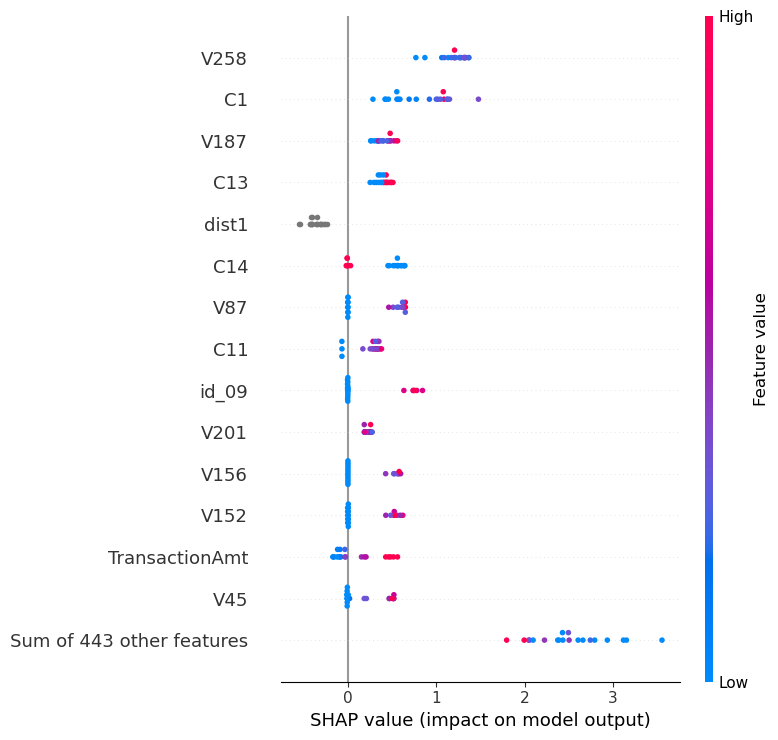

SHAP analysis complete


In [42]:
print('Computing SHAP values for XGBoost (top 20 predictions)...')

# Get top 20 highest-scored predictions for explanation
top_indices = np.argsort(xgb_test_proba)[-20:][::-1]
X_explain   = X_test[top_indices]

explainer   = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_explain)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_explain,
    feature_names=feature_cols,
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title('SHAP Feature Importance (Top 20 Predictions)')
plt.tight_layout()
plt.savefig('reports/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Beeswarm plot
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_explain,
    feature_names=feature_cols
)
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_explanation, max_display=15, show=False)
plt.tight_layout()
plt.savefig('reports/shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

print('SHAP analysis complete')

## 14. False Positive Analysis

In [43]:
# Identify top 10 false positives
# False positives: predicted fraud (high score) but actually legitimate

test_df_analysis = df_test[feature_cols + ['isFraud', 'TransactionID', 'TransactionAmt', 'card1']].copy()
test_df_analysis['xgb_score']   = xgb_test_proba
test_df_analysis['xgb_pred']    = xgb_results['y_pred']

false_positives = test_df_analysis[
    (test_df_analysis['xgb_pred'] == 1) &
    (test_df_analysis['isFraud']  == 0)
].sort_values('xgb_score', ascending=False).head(10)

print(f'Total false positives in test set: {len(test_df_analysis[(test_df_analysis["xgb_pred"]==1) & (test_df_analysis["isFraud"]==0)])}')
print(f'\nTop 10 False Positives:')
print(false_positives[['TransactionID', 'TransactionAmt', 'card1', 'xgb_score',
                         'composite_behavioral_risk', 'composite_velocity_risk',
                         'composite_network_risk', 'card_amt_zscore']].to_string(index=False))

Total false positives in test set: 937

Top 10 False Positives:
 TransactionID  TransactionAmt  TransactionAmt  card1  card1  xgb_score  composite_behavioral_risk  composite_velocity_risk  composite_network_risk  card_amt_zscore
       3569342         78.3870         78.3870   8755   8755     0.9993                     0.1576                   0.0012                  0.8090           0.7770
       3569699        130.6450        130.6450  17147  17147     0.9991                     0.1515                   0.0087                  0.8090           2.7656
       3569645        130.6450        130.6450  10876  10876     0.9990                     0.1780                   0.0022                  0.8090           2.1501
       3569682        130.6450        130.6450   9300   9300     0.9979                     0.1743                   0.0019                  0.8090           2.6319
       3525595         15.2470         15.2470  10568  10568     0.9964                     0.0324             

In [45]:
fp_indices   = false_positives.index[:5]
fp_positions = [list(df_test.index).index(idx) for idx in fp_indices if idx in list(df_test.index)]

if fp_positions:
    X_fp    = X_test[fp_positions]
    shap_fp = explainer.shap_values(X_fp)

    for i, pos in enumerate(fp_positions):
        amt       = test_df_analysis.loc[list(df_test.index)[pos], 'TransactionAmt']
        amt       = float(amt.values[0]) if hasattr(amt, 'values') else float(amt)
        score     = float(xgb_test_proba[pos])

        print(f'\nFalse Positive #{i+1} - TransactionAmt: {amt:.2f}')
        print(f'XGBoost Score: {score:.4f}')

        top_features = sorted(
            zip(feature_cols, shap_fp[i]),
            key=lambda x: abs(x[1]),
            reverse=True
        )[:5]

        for feat, shap_val in top_features:
            print(f'  {feat}: SHAP = {shap_val:.4f}')


False Positive #1 - TransactionAmt: 78.39
XGBoost Score: 0.9993
  V258: SHAP = 1.3684
  id_09: SHAP = 0.8430
  C14: SHAP = 0.6433
  V87: SHAP = 0.6098
  V45: SHAP = 0.5184

False Positive #2 - TransactionAmt: 130.65
XGBoost Score: 0.9991
  V258: SHAP = 1.3175
  id_09: SHAP = 0.7777
  C1: SHAP = 0.6911
  V87: SHAP = 0.6135
  C14: SHAP = 0.6069

False Positive #3 - TransactionAmt: 130.65
XGBoost Score: 0.9990
  V258: SHAP = 1.3139
  id_09: SHAP = 0.7359
  C14: SHAP = 0.6370
  V87: SHAP = 0.6227
  C1: SHAP = 0.5673

False Positive #4 - TransactionAmt: 130.65
XGBoost Score: 0.9979
  V258: SHAP = 1.4254
  id_09: SHAP = 0.7363
  C14: SHAP = 0.6781
  C1: SHAP = 0.6727
  V87: SHAP = 0.6211

False Positive #5 - TransactionAmt: 15.25
XGBoost Score: 0.9964
  V258: SHAP = 1.3478
  C1: SHAP = 1.1475
  dist1: SHAP = -0.5238
  V45: SHAP = 0.4954
  V87: SHAP = 0.4582


In [46]:
# Save feature columns and model metadata
model_metadata = {
    'model_version'    : 'v1.0.0',
    'training_date'    : datetime.now().isoformat(),
    'feature_cols'     : feature_cols,
    'n_features'       : len(feature_cols),
    'xgb_val_auc'      : float(xgb_val_auc),
    'xgb_test_auc'     : float(xgb_results['auc_roc']),
    'nn_test_auc'      : float(nn_results['auc_roc']),
    'xgb_threshold'    : float(xgb_results['opt_threshold']),
    'fill_values_path' : 'models/fill_values.pkl',
    'encoding_maps_path': 'models/encoding_maps.pkl',
}

joblib.dump(fill_values, MODEL_DIR / 'fill_values.pkl')

with open(MODEL_DIR / 'model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2, default=str)

print('All models and metadata saved to models/ directory')
print('\nFinal Summary:')
print(f'XGBoost Test AUC-ROC  : {xgb_results["auc_roc"]:.4f}')
print(f'XGBoost Test AUC-PR   : {xgb_results["auc_pr"]:.4f}')
print(f'Neural Net Test AUC-ROC: {nn_results["auc_roc"]:.4f}')
print(f'Neural Net Test AUC-PR : {nn_results["auc_pr"]:.4f}')
print(f'Total engineered features: {len(all_engineered_features)}')

All models and metadata saved to models/ directory

Final Summary:
XGBoost Test AUC-ROC  : 0.8947
XGBoost Test AUC-PR   : 0.4962
Neural Net Test AUC-ROC: 0.4278
Neural Net Test AUC-PR : 0.0544
Total engineered features: 29
